### Importation des bilbliothèques

In [4]:
import matplotlib.pyplot as plt

import numpy as np

import cv2
import time
from skimage import color, transform
from skimage.feature import hog
import imutils

import joblib

In [36]:
(winH, winW) = (62, 47)

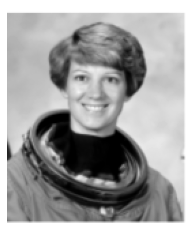

In [25]:
test_image = cv2.imread('img/astronaut.png') 
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
test_image = test_image[:160, 20:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Ici, on va mettre en place les méthodes de image pyramid et sliding window

In [34]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        
        yield image

In [40]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[1], stepSize):
        for x in range(0, image.shape[0], stepSize):
            yield (x, y, image[x:x + windowSize[0], y:y + windowSize[1]])

In [39]:
def sliding_window2(img, patch_size,
                   istep=4, jstep=4, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

### Extraction des patches

In [43]:
#indices, patches = [], []
#for (i, resized) in enumerate(pyramid(test_image)):
#    try:
#       pyrindices, pyrpatches = zip(*sliding_window(resized, positive_patches_shape, scale=1.0))
#        indices += pyrindices
#        patches += pyrpatches
#    except:
#        pass
 
indices, patches = [], []

for resized in pyramid(test_image, scale=1.5):
    for (i, j, window) in sliding_window(resized, stepSize=8, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        indices.append((i, j))
        patches.append(window)
    
indices = np.array(indices)

Ni, Nj = positive_patches_shape
indices = np.array(indices)

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
            
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

ValueError: negative dimensions are not allowed

### Prédiction

In [29]:
# Chargement du modèle
filename = 'temp_model.sav'
loaded_model = joblib.load(filename)

# Prédictions
labels = loaded_model.predict(patches_hog)
print("{} zones positives trouvées.".format(labels.sum()))

14.0 zones positives trouvées.


### Affichage des résultats

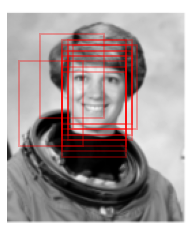

In [30]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches_shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Il faut encore combiner les patches qui se superposent